In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from pyspark.mllib.stat import Statistics
%matplotlib inline

import findspark
findspark.init()

# Import and start a Spark session.
from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, StringType

spark = SparkSession.builder.getOrCreate()
plt.rcParams['figure.figsize'] = [12, 8]

# Analyze of hashtags as a whole

The first part of our work is the analysis of how hashtags behave. Here, we want to understand the general behavior. A more precise analyse on specific hashtags will come latter.

## Creating our datasets

As the twitter dataset is huge, we can't work directly on it, we must find a way to extract insights from it that are usefull from our analysis. We are particularly interested in two metrics: 
- the count of tweets having a given hashtag
- the exposure (which we are calling "print") of tweets having a given hashtag. The exposure of a tweet is defined as an approximation of the audience reached by it, which is approximately the number of followers of the author. Then, we can approximate the exposure of several tweets by the sums of the followers of every authors. This is an over approximation as some users could have common followers, but it should be good enough.

Then, for each hashtag $h$ we are extracting the following insights:
- the total count of tweets having the hashtag $h$
- for each day the total count of tweets having the hashtag $h$ and tweeted on this day
- the exposure of tweets having the hashtag $h$
- for each day the exposure of tweets having the hashtag $h$ and tweeted on this day

More concretely, we ran the script `hashtag_insights.py` for each month on the cluster. Then, we merged the insights of different months as explained below.

### Merging of monthly insights into an insights dataframe.

We start by loading our monthly insights extracted from the cluster. We load every month of 2017 at the exception of:
- January, as we never managed to open it on the cluster
- June, as it contain nearly no data on the cluster
- December as it was absent of the cluster

In [26]:
def load_insights(months):
    return {month: spark.read.parquet('hashtags_insights_{}.parquet'.format(month)) for month in months} 

hashtags = load_insights(['02', '03', '04', '05', '07', '08', '09', '10', '11'])

For reasons we didn't understood, our hashtags insights for the month of augusts contained some duplicates rows. Hence, we remove them before continuing our analysis.

In [ ]:
hashtags['08'] = hashtags['08'].dropDuplicates()

For each monthly hashtags, some days could be absent (which is the case for the month of November where the 19th, 20th, 21st, 22nd, 23rd, 24th and 25th are missing). We remove the corresponding rows. For rows that still exists we prefix them. As rows `count` and `print` can be recomputed easily, to avoid any conflicts when joining the monthly insights we remove them.

In [ ]:
def rename_columns(insights, prefix):
    printCols = [c for c in insights.columns if "print_" in c]
    nameCols = [c for c in insights.columns if "count_" in c]
    print(insights, prefix)
    for x in printCols + nameCols:
        if insights.where(F.col(x) != 0).count() == 0:
            insights = insights.drop(x)
        else:
            insights = insights.withColumnRenamed(x, prefix + "_" + x)
    return insights.drop("count").drop("print")

In [ ]:
insights = [rename_columns(hashtags[key], key) for key in hashtags]

We now join every monthly hashtags by using an outer join.

In [ ]:
from functools import reduce

def joinAll(dfs):
    return reduce(lambda prev, cur: cur.join(prev, on='tag', how='outer'), dfs)

In [ ]:
unifiedInsights = joinAll(insights)

We then replace Nan entries by 0 and we recompute rows `count` and `print`.

In [ ]:
unifiedInsights = unifiedInsights.fillna(0).cache()
count_columns = [c for c in unifiedInsights.columns if "count" in c]
unifiedInsights = unifiedInsights.withColumn("count", sum(F.col(c) for c in count_columns))
print_columns = [c for c in unifiedInsights.columns if "print" in c]
unifiedInsights = unifiedInsights.withColumn("print", sum(F.col(c) for c in print_columns))

Finally we export this dataset to a parquet file.

In [ ]:
unifiedInsights.write.mode("overwrite").parquet("hashtags-insights.parquet")

### Building a "compressed insights" from our insights.

For convenience, we also decided to build a new dataset from the previous one. The main difference is in how we store the count per day and the print per day. In the previous dataset we had one column per day for the count and the exposure. In the one we will be building, we will have a row which will be an array of counts, and a row which will be an array of exposure (the ith entry maps to day i). These arrays will be relative to the row count and print, that is normalized between 0 and 1. This allows us to compare the behavior of two hashtags more accurately.

In [232]:
insights = spark.read.parquet("hashtags-insights.parquet")

We first build a time-sorted list of names of columns corresponding to a hashtag count. We also build the equivalent for the exposure.

In [233]:
def key(c):
    """ Parse a column name of the form month_(print|count)_day in a tuple (month, day)"""
    month, _, day = c.split("_")
    return int(month), int(day)


count_columns_wkey = [(c, key(c)) for c in insights.columns if "count_" in c]
count_columns_wkey.sort(key=lambda x: x[1])
count_columns = [a for a, _ in count_columns_wkey]
count_days = [b for _, b in count_columns_wkey]

print_columns_wkey = [(c, key(c)) for c in insights.columns if "print_" in c]
print_columns_wkey.sort(key=lambda x: x[1])
print_columns = [a for a, _ in print_columns_wkey]
print_days = [b for _, b in print_columns_wkey]

We create a new column `count_daily` which will be the array of normalized daily counts and drop the columns that have become useless.

In [ ]:
insights_compressed = \
    insights \
    .withColumn("count_daily", F.array(*[F.col(c) / F.col('count') for c in count_columns])) \
    .select(*[c for c in insights_compressed.columns if not c in count_columns])

We know do the same to add `print_daily`, which is the equivalent of `count_daily` but for the exposure.

In [ ]:
insights_compressed = \
    insights_compressed \
    .withColumn("print_daily", F.array(*[F.col(c) / F.col('print') for c in print_columns])) \
    .select(*[c for c in insights_compressed.columns if not c in print_columns])

Then we export the resulting dataset to a parquet file.

In [ ]:
insights_compressed.write.parquet("insights-compressed.parquet")

## Analysis of hashtags insight

We start by loading our two datasets:

In [2]:
insights = spark.read.parquet("hashtags-insights.parquet")

In [3]:
insights_compressed = spark.read.parquet("insights-compressed.parquet")

### General statistics

We have around 15 million different hashtags in the dataset.

In [32]:
insights.count()

15177260

The average exposure is of 134 thousand people, while on average an hashtag appears 21 time in our dataset. Do not forget that we extracted the hashtags from a 1% sample of twitter, hence the truth is that the true average of the number of occurences is more likely to be around 2100.

In [34]:
insights.agg({"count": "avg", "print": "avg"}).show()

+------------------+------------------+
|        avg(print)|        avg(count)|
+------------------+------------------+
|134616.39214831925|21.220559969322526|
+------------------+------------------+



However, the average count, and even the average print are completly biased by the outliers. The median of the count is 1!

In [44]:
insights.approxQuantile('count', [.25, .5, .75], .001)

[1.0, 1.0, 3.0]

In [38]:
insights.approxQuantile('print', [.25, .5, .75], .001)

[143.0, 710.0, 3968.0]

**Analyse of the distribution of the number of occurences**

In fact, only 38% of the hashtags are present more than once.

In [51]:
100 * float(insights.where(F.col('count') > 1).count()) / float(insights.count())

38.79508554244969

More surprisingly, .78% of hashtags are present at least 250 times. 

In [224]:
100 * float(insights.where(F.col('count') > 250).count()) / float(insights.count())

0.7877377075967599

Starting from now, we will pursue our analysis only on hashtags occuring more than 250 times: this a good compromise about "generality" and focusing on "viral" tweets.

In [125]:
THRESHOLD_COUNT = 250

The histogram of the number of occurences shows clearly that the number of occurences is sharply decreasing.
The noise at the start of the histogram might be due to the sampling: missing one tweet out of 50 is more impactfull than one tweet out of 250. 

In [95]:
bins, counts = insights.where(F.col('count') > 50) \
        .select(F.log10('count')).rdd \
        .flatMap(lambda x: x) \
        .histogram(150)

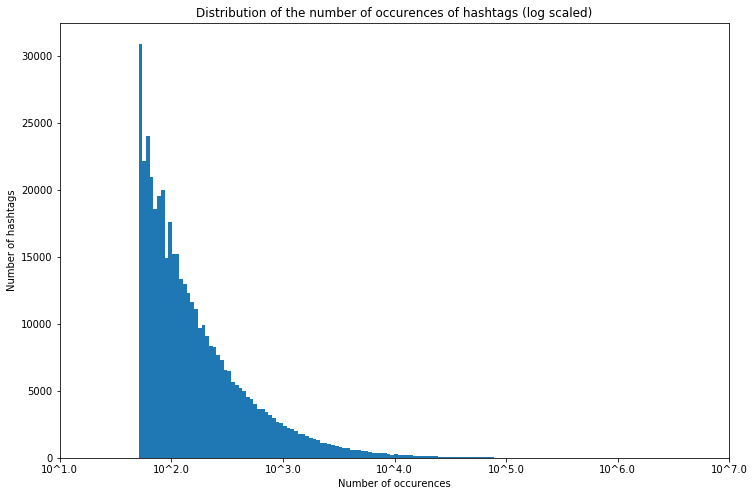

In [96]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of the number of occurences of hashtags (log scaled)' )
plt.ylabel('Number of hashtags')
plt.xlabel('Number of occurences')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

In fact, it is even following a power-law:

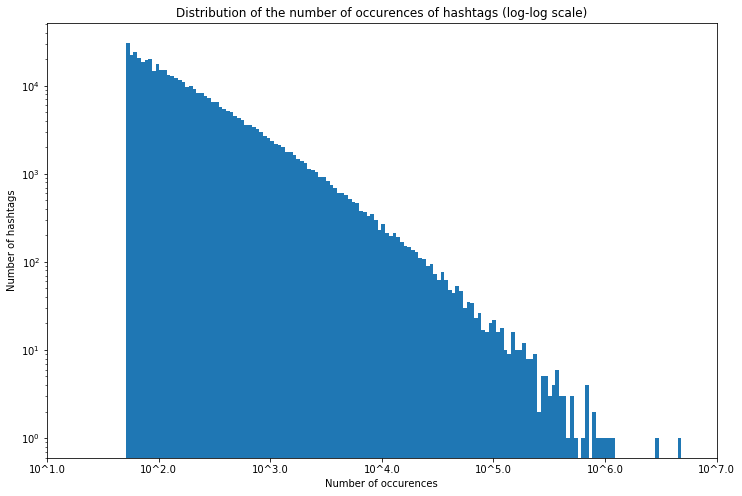

In [98]:
plt.hist(bins[:-1], bins=bins, weights=counts, log=True)
plt.title('Distribution of the number of occurences of hashtags (log-log scale)' )
plt.ylabel('Number of hashtags')
plt.xlabel('Number of occurences')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

**Analyse of the distribution of the exposure**

Once again we plot the log distribution of the exposure. We chose to use a threshold of 250000: only 2.9% of the tweets have a bigger exposure.

In [226]:
100 * float(insights.where(F.col('print') > 250000).count()) / float(insights.count())

2.869944904416212

In [228]:
bins, counts = insights.where(F.col('print') > 250000) \
        .select(F.log10('print')).rdd \
        .flatMap(lambda x: x) \
        .histogram(150)

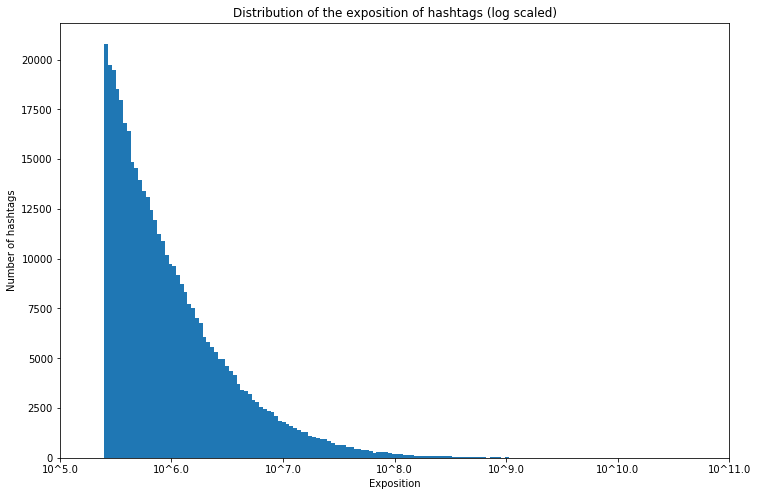

In [229]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of the exposition of hashtags (log scaled)' )
plt.ylabel('Number of hashtags')
plt.xlabel('Exposition')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

Once again, we also plot the distribution on a log-log scale. Apparently it does not follow a power law.

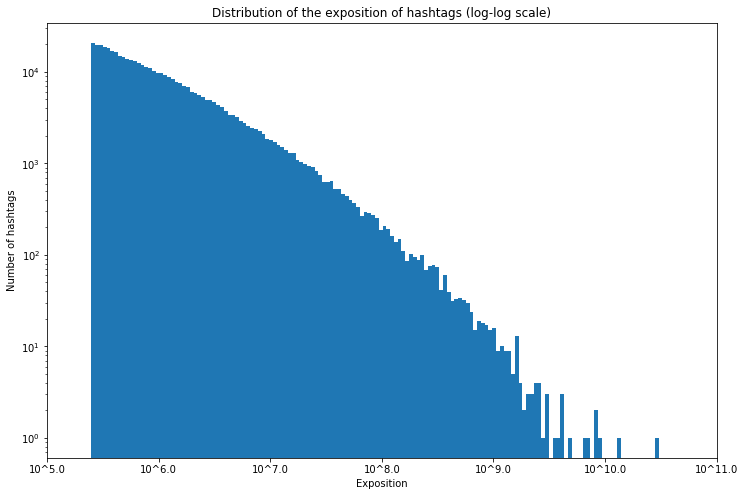

In [230]:
plt.hist(bins[:-1], bins=bins, weights=counts, log=True)
plt.title('Distribution of the exposition of hashtags (log-log scale)' )
plt.ylabel('Number of hashtags')
plt.xlabel('Exposition')
locs, _ = plt.xticks()
labels = ["10^{}".format(l) for l in locs]
plt.xticks(locs, labels);

In [126]:
insights_r = insights.where(F.col('count') > THRESHOLD_COUNT).cache()

### Correlation between exposure and number of occurence.

Our intuition is that the exposure of a given hashtag, and its number of occurences are correlated. We wanted to validate this hypothesis by checking it on the dataset.

The first step is to compute spearman correlation coefficient. At 0.45, we can hope for the exposure and the number of occurences to be correlated.

In [143]:
features = insights_r.select("count", "print").rdd.map(lambda row: row[0:])
corr = Statistics.corr(features, method="spearman")

In [144]:
corr[0][1]

0.45635800425950807

However, it is always usefull to check our results visually. We first plot all points (count, print) in a scatter plot.

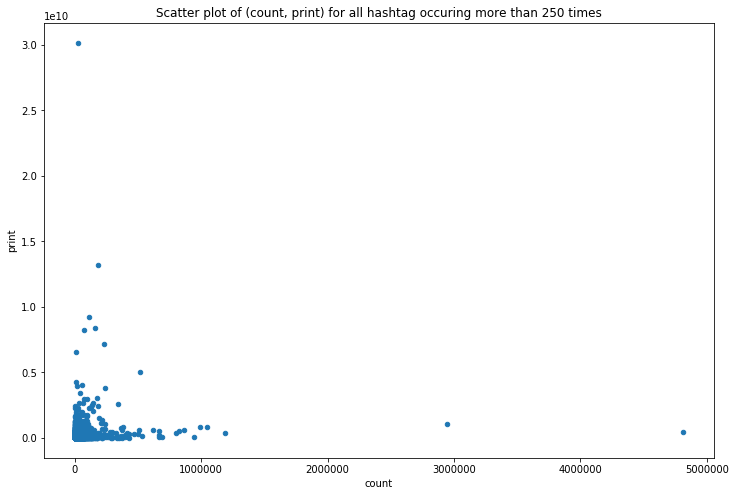

In [216]:
# the projection is small enough to fit in memory
sample = insights_r.select("tag", "count", "print").toPandas()
sample.plot.scatter('count', 'print')
plt.title('Scatter plot of (count, print) for all hashtag occuring more than 250 times');

Most of our data is in the bottom left corner. We will zoom on this corner.

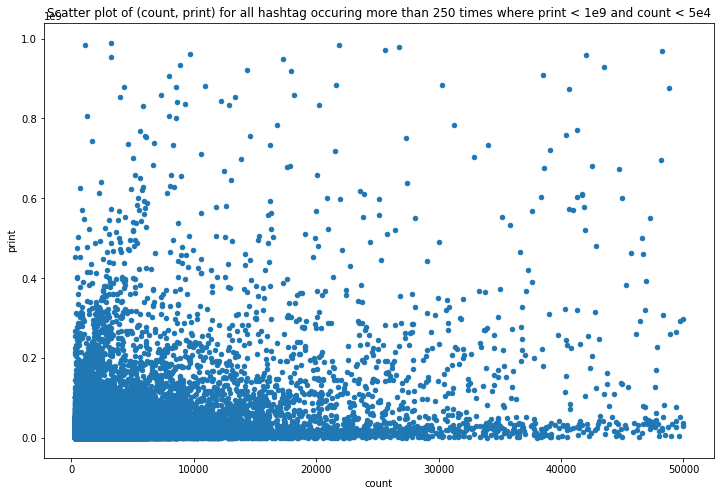

In [223]:
sample = \
    insights_r \
    .where((F.col('count') < 50000) & (F.col('print') < .1 * 1e10)) \
    .select("tag", "count", "print") \
    .toPandas()
sample.plot.scatter('count', 'print')
plt.title('Scatter plot of (count, print) for all hashtag occuring more than 250 times where print < 1e9 and count < 5e4');

Even zoomed in, we can't see a general trend. Most of the points seems to be clustered together.

We have two explanations of why we have not found a correlation between exposure and number of exposure:
- Either this correlation doesn't exists
- Either the exposure we computed is wrong. Right now it is highly dependant on who tweeted a tweet. For exemple, a user with one million follower will impact more the exposure than one thousand users with one hundred followers. However, given that users with a high number of followers are less numerous than other users, as our twitter sampled was uniformly sampled, this problem should not be present as it should have been compensated.

### Distribution of tweets

The distribution of tweets might be interesting to study. We will plot it below.

In [321]:
sum_count_day_pd = \
    insights_r \
    .agg(*[F.sum(F.col(c)).alias(c) for c in count_columns]) \
    .toPandas()

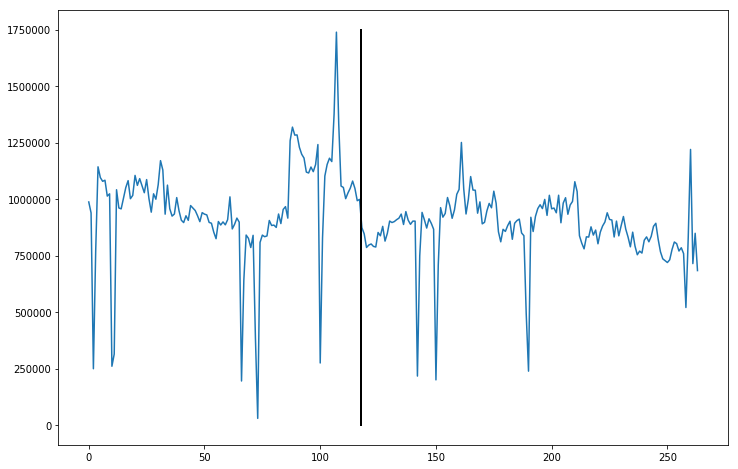

In [322]:
plt.plot( range(0, len(count_columns)), sum_count_day_pd.loc[0].values);
plt.plot([117.5, 117.5], [0, 1750000], 'k-', lw=2)

We also display the number of active hashtags per days.

In [319]:
sum_hashtags_day_pd = \
    insights_r \
    .agg(*[F.sum((F.col(c) > 0).cast('long')).alias(c) for c in count_columns]) \
    .toPandas()

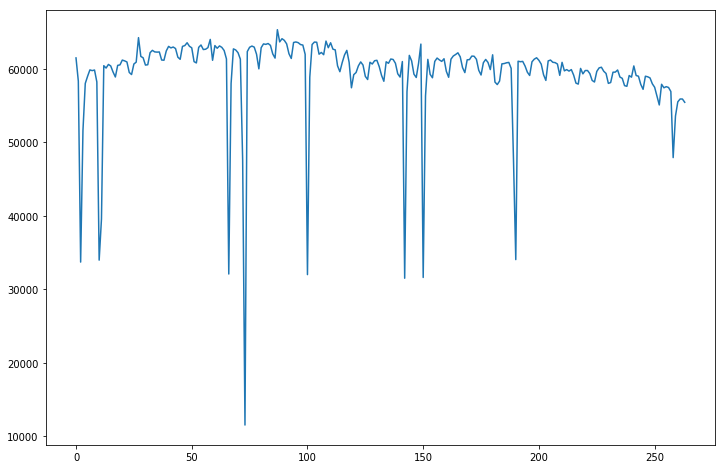

In [323]:
plt.plot( range(0, len(count_columns)), sum_hashtags_day_pd.loc[0].values);

In [289]:
sum_count_day_pd.T.min(), sum_count_day_pd.T.max()

(0    29464
 dtype: int64, 0    1739101
 dtype: int64)

In [297]:
sum_count_day_pd.T[sum_count_day_pd.T[sum_count_day_pd.T.columns[0]] == 29464]

0
04_count_17  29464

Please keep in mind that some days (or even the full month of June) are missing. For example, here even the point with x coordinate 117 is the 31 may but the point with x coordinate 118 is the first July. This gap is represented by the black line.

What is suprising is the disparity between the number of tweets per days. For exemple, the 17th April has only 29464 tweets whereas the 21st May has more than 1739101 tweets. 

We think that
Manchester Arena bombing

In [305]:
tags_25_21 = insights.where(F.col('05_count_21') > 0).select('tag', 'count', 'print').toPandas()

In [324]:
tags_25_21.sort_values('count', ascending=False)

tag    count       print
207788                   izmirescort  4813484   473402849
194720                      BTSBBMAs  2943069  1054566200
194974                    MTVHottest  1188991   408684695
275256                           BTS  1048438   856258406
272538                         방탄소년단   992185   805900903
13315                     bucaescort   946477   103901599
144982                         BBMAs   865828   591855353
180961                          GOT7   825628   559620828
53751                 PREMIOSMTVMIAW   798094   366569035
238236                   เป๊กผลิตโชค   691987    74748357
201726                  KCAPinoyStar   670038   115889180
49340                            EXO   669418   540419015
177288                  iHeartAwards   621067   643349708
273137                     VideoLove   536245   178164941
21549                     NowPlaying   518356  4999538651
116179                         JIMIN   498152   325841389
173590                           갓세븐   466638   324929219
150320                     사설토토사이트추천   427497    26436512
152385                 bornovaescort   424065    42764181
183654                   BestFanArmy   417604   408998911
272764                 CamilaCabello   398845   256325563
217368                   escortizmir   395945    64181189
201478                             ﷺ   384633   828184879
136995                 NewProfilePic   376792   616350445
97664                           トレクル   373388    11126929
244319                        MTVEMA   370220   158601649
141223                 RTした人全員フォローする   368407   766739666
20071                   NadineLustre   364125    88037542
22466                      사설토토추천사이트   348880    15277032
22978                             RT   341114  2631600802
...                              ...      ...         ...
203223                  MoneyDabOnEm        1           1
203220                  MilestonePod        1          30
203216                MentalManadhil        1         650
203215              MeltedMozzarella        1         155
203136               Hazardouswastes        1         211
53106                        居眠りイエロー        1          72
53103                      学生トライアングル        1        1707
203153               I_Deserve_It_Ep        1         275
203156         ImposibleNoTararearla        1         252
53100                            太夫浜        1         173
53099                        大阪らりあっと        1         395
203161                    JPelirrojo        1         168
203162                 JackedContent        1         212
53096                         大きめの水槽        1        3256
203175                    KarlSlater        1        6056
203176               KeepShastaClean        1          68
203178              KfouriansDesigns        1        1462
53090                           古北水镇        1          10
53078                  乃木坂と関係ないけど許して        1        1710
53075                          一目百万本        1        1570
53071                           ロクイチ        1           2
203197                         Logio        1        2232
203199                       LumixG8        1        1263
203200  LunesDelPreguntónDeFrancisco        1          23
203202                    MATAMOSCAS        1         871
203206                       ManisFM        1        1143
53066                     モデルハウスオープン        1         363
53065                        メルリーちゃん        1         372
203214              MediaMobviolence        1        1265
276508               ＲＴかいいね来ても何も話さない        1         846

[276509 rows x 3 columns]

In [330]:
izmirescort = insights_compressed.where(F.col('tag') == "izmirescort").toPandas()

In [331]:
izmirescort

tag    count      print  \
0  izmirescort  4813484  473402849   

                                         count_daily  \
0  [0.0005796217459121086, 0.0003899462426799383,...   

                                         print_daily  
0  [0.0008225721514405165, 0.000813315764392453, ...

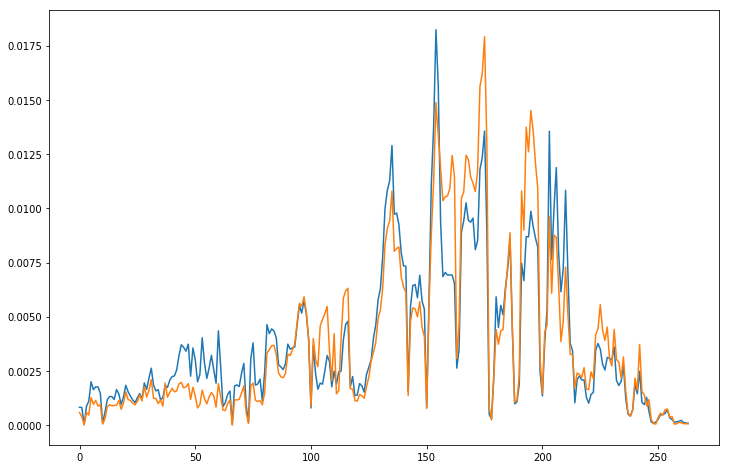

In [348]:
plt.plot(izmirescort.print_daily.values[0])
plt.plot(izmirescort.count_daily.values[0])

In [343]:
len(izmirescort.print_daily.values[0])

264

In [302]:
tags_25_21

265852

In [277]:
count_days[118]

(7, 1)

In [ ]:
plt.plot()

## Analyze of the alphabet used in the hashtag

One interesting point to study is to study if the country of the hashtags impact the number of occurences. In our insights we don't have access to the language of the tweet. However, as the hashtags are some UTF-8 strings, we can extrapolate the alphabet (cyrillic, arabic, chinese, japanese, korean, latin) used. The alphabet itself is a good approximation of the language.

In [349]:
import re
# we first define the character range for the different alphabet in utf-8
cyrillic = "[\u0400-\u04FF\u0500-\u052F]"
arabic = "[\u0600-\u06FF\u0750-\u077F\uFB50-\uFDFF\uFE70-\uFEFF]"
chinese = "[\u2E80-\u2EFF\u3000-\u303F\u3100-\u312F\u31A0-\u31BF\u31C0-\u31EF\u3200-\u32FF\u3300-\u33FF\u3400-\u4DBF\u4E00-\u9FFF\uF900-\uFAFF\uFE30-\uFE4F]"
japanese = "[\u3040-\u309F\u30A0-\u30FF\u31F0-\u31FF]"
korean = "[\u1100-\u11FF\u3130-\u318F\uAC00-\uD7AF]"
re_cyrillic = re.compile(cyrillic, re.UNICODE)
re_arabic = re.compile(arabic, re.UNICODE)
re_chinese = re.compile(chinese, re.UNICODE)
re_japanese = re.compile(japanese, re.UNICODE)
re_korean = re.compile(korean, re.UNICODE)


def approximateCountry(tag):
    """ Given a string [tag], return a string corresponding to the alphabet used"""
    if re_cyrillic.search(tag) is not None:
        return "cyrillic"
    elif re_arabic.search(tag) is not None:
        return "arabic"
    elif re_chinese.search(tag) is not None:
        return "chinese"
    elif re_japanese.search(tag) is not None:
        return "japanese"
    elif re_korean.search(tag) is not None:
        return "korean"
    else:
        return "latin"
    
udfapproximateCountry = F.udf(approximateCountry, StringType())

In [127]:
insights_alphabet = insights_r.withColumn("alphabet", udfapproximateCountry(F.col('tag')))

We now compute the proportion of hashtags made in each alphabet for an increasing threshold on the number of occurences of hashtag.
More simply said, we want to know the proportion of hashtags written in chinese among all hashtags occuring more than 250 times, then the proportion for hashtags occuring more than 500 times, etc...

In [357]:
language_df = pd.DataFrame()
thresholds = list(range(250, 100001, 1000))
for t in thresholds:
    filtered = \
        insights_alphabet \
        .where(F.col('count') > t) 
    count = filtered.count()
    temp = \
        filtered \
        .groupby('alphabet') \
        .agg((F.count(F.lit(1)) / count).alias('count_' + str(t))) \
        .toPandas()
    language_df = pd.concat([language_df, temp.set_index('alphabet').T], ignore_index=True, sort=True)

In [358]:
language_df = language_df.fillna(0)
language_df['threshold'] = thresholds

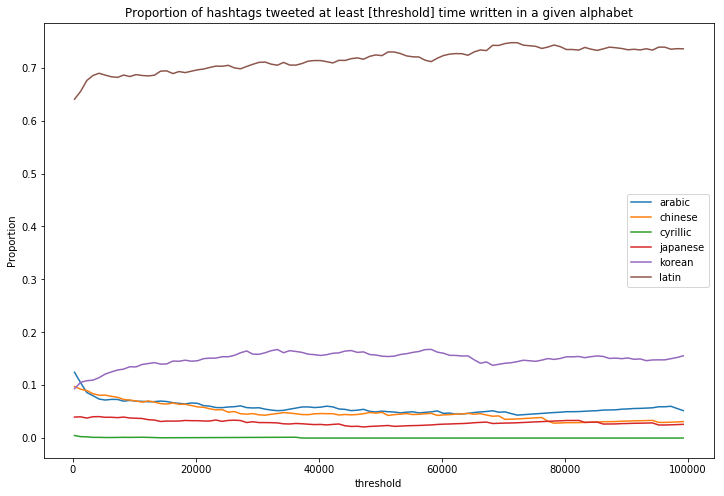

In [359]:
language_df.plot(x='threshold', y=[col for col in language_df.columns if col != 'threshold'])
plt.ylabel('Proportion');
plt.title('Proportion of hashtags tweeted at least [threshold] time written in a given alphabet');

Interestingly, the alphabet used have nearly no influence on the popularity (defined as the count) of an hashtag. The proportion of hashtags written in chinese (for example) is nearly always constant.

## Clustering to find similar trends

In [47]:
sample_ic_pd = insights_compressed.where(F.col('count') > 250).sample(False, .005).toPandas()

In [48]:
sample_ic_pd.shape

(575, 5)

In [57]:
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
from scipy.spatial.distance import pdist, squareform
from fastdtw import fastdtw

In [155]:
values = sample_ic_pd.count_daily.map(lambda x: (np.array(x) - np.mean(x)) / np.std(x)).values

In [156]:
values

array([array([-0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864, -0.07848864,
       -0.07848864, -0.07848864, -0.07848864, -0.07848864

In [157]:
dist_matrix =\
    squareform(pdist(
        pd.DataFrame(values.tolist(), index=sample_ic_pd.index), 
        lambda a, b : fastdtw(a, b)[0]))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [158]:
dist_matrix

array([[  0.        ,  41.36908777, 209.62624378, ...,   9.85409129,
         59.46865413,   6.65233866],
       [ 41.36908777,   0.        , 202.8198814 , ...,   7.46074803,
         89.00718744,  40.94033065],
       [209.62624378, 202.8198814 ,   0.        , ..., 203.5014087 ,
        204.27005096, 206.95405966],
       ...,
       [  9.85409129,   7.46074803, 203.5014087 , ...,   0.        ,
         64.76487184,   9.19732241],
       [ 59.46865413,  89.00718744, 204.27005096, ...,  64.76487184,
          0.        ,  64.43046609],
       [  6.65233866,  40.94033065, 206.95405966, ...,   9.19732241,
         64.43046609,   0.        ]])

In [168]:
def doAgglomerative(X, nclust=2):
    model = AgglomerativeClustering(n_clusters=nclust, affinity = 'precomputed', linkage = 'average')
    labels = model.fit_predict(X)
    return labels

labels = doAgglomerative(dist_matrix, 10)

In [160]:
labels

array([3, 3, 9, 3, 2, 3, 3, 8, 3, 3, 3, 3, 4, 5, 3, 1, 8, 8, 3, 3, 5, 3,
       3, 3, 4, 4, 0, 0, 3, 8, 3, 3, 3, 6, 5, 8, 9, 0, 3, 3, 1, 3, 3, 8,
       6, 3, 3, 3, 3, 3, 9, 7, 3, 3, 5, 1, 3, 3, 9, 1, 7, 3, 0, 3, 7, 3,
       3, 7, 0, 3, 3, 3, 3, 7, 4, 8, 1, 9, 3, 3, 3, 2, 3, 3, 7, 3, 3, 3,
       2, 3, 4, 3, 3, 3, 3, 3, 7, 6, 0, 2, 3, 7, 6, 3, 0, 3, 1, 3, 3, 0,
       3, 3, 8, 2, 3, 3, 3, 3, 0, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 8,
       8, 3, 3, 3, 3, 5, 3, 3, 3, 2, 3, 6, 2, 3, 3, 3, 1, 6, 6, 3, 3, 3,
       3, 3, 7, 3, 3, 0, 7, 3, 3, 4, 8, 3, 3, 3, 3, 1, 7, 3, 3, 4, 5, 2,
       0, 3, 3, 0, 3, 1, 3, 7, 9, 7, 7, 3, 3, 3, 8, 2, 0, 3, 8, 0, 3, 3,
       8, 1, 6, 3, 4, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 7, 3, 3, 8,
       4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 7, 3, 8, 3, 7, 3, 3,
       8, 3, 3, 3, 3, 7, 1, 8, 3, 3, 3, 3, 3, 5, 3, 3, 4, 3, 3, 1, 0, 3,
       3, 7, 4, 8, 3, 4, 7, 3, 9, 8, 3, 0, 1, 3, 0, 3, 8, 0, 3, 3, 0, 3,
       9, 3, 7, 3, 3, 1, 3, 3, 9, 3, 3, 3, 1, 3, 3,

/home/pierre/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


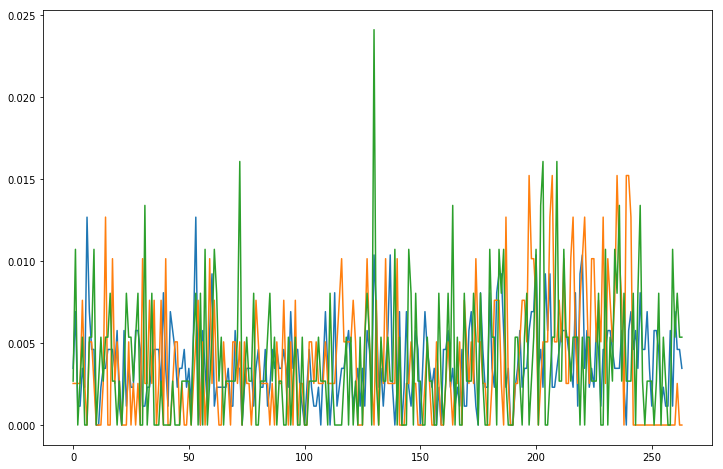

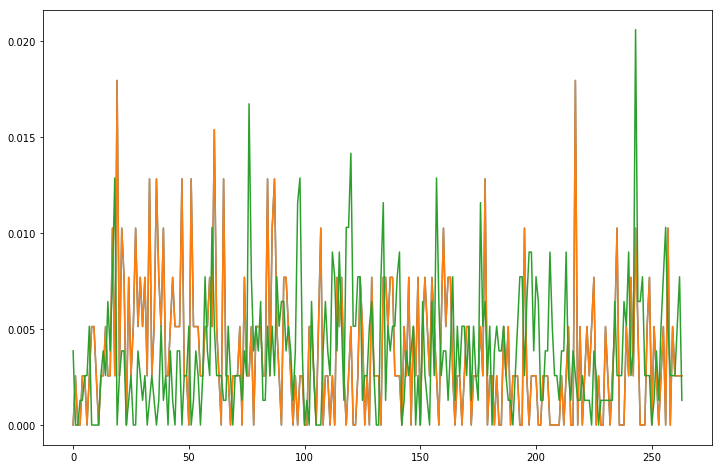

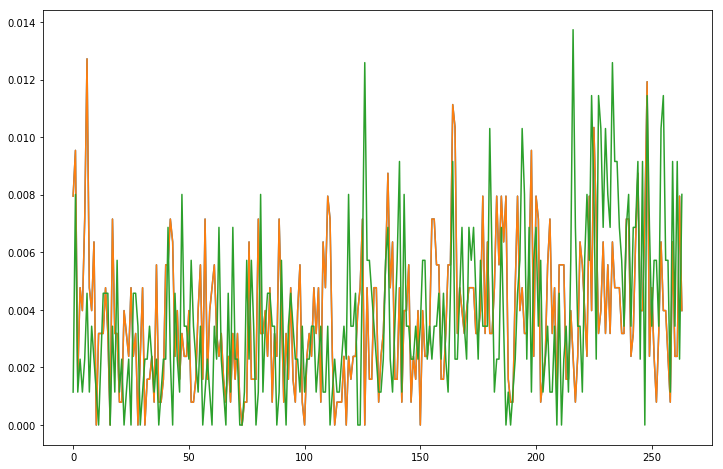

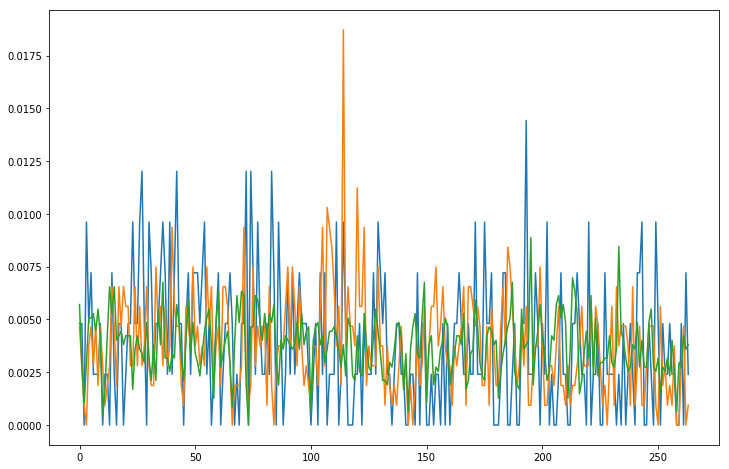

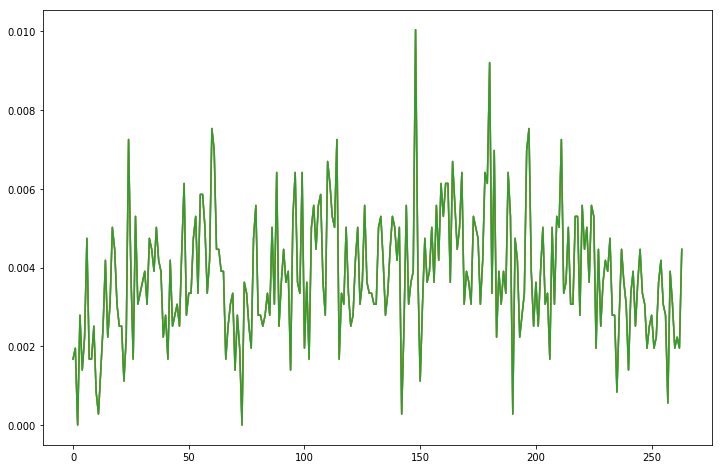

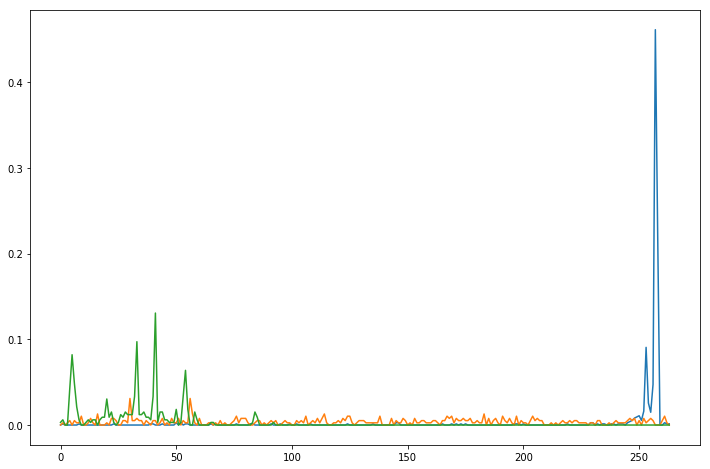

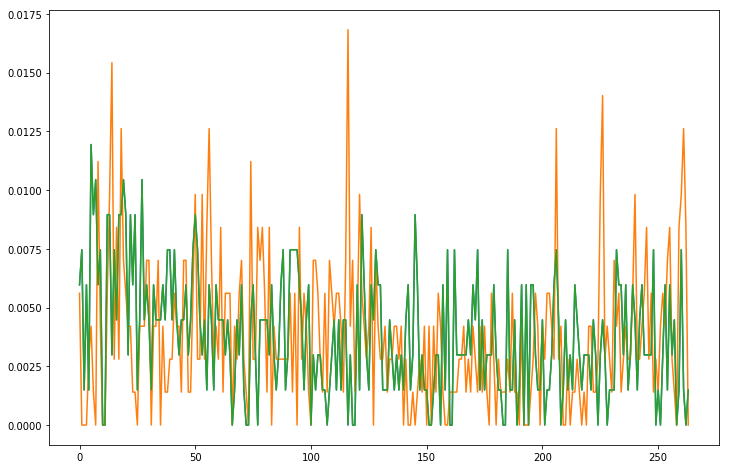

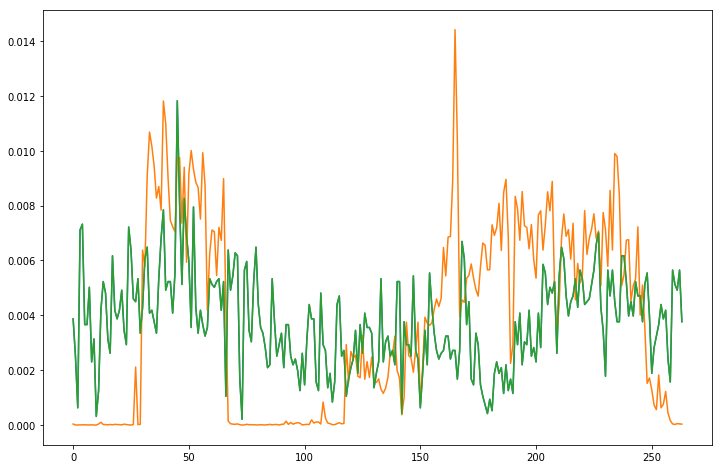

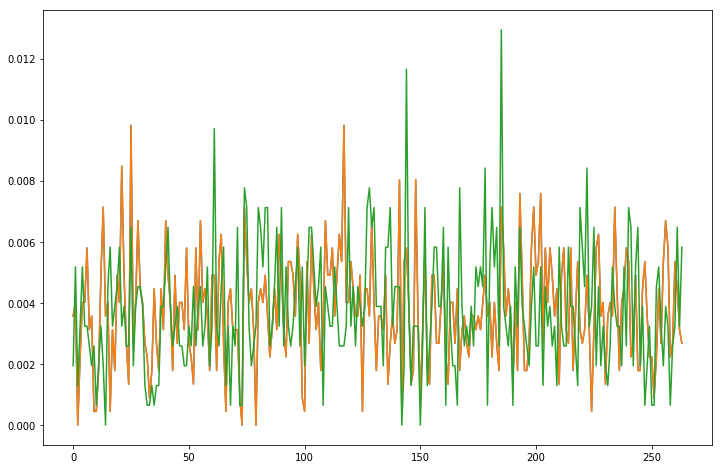

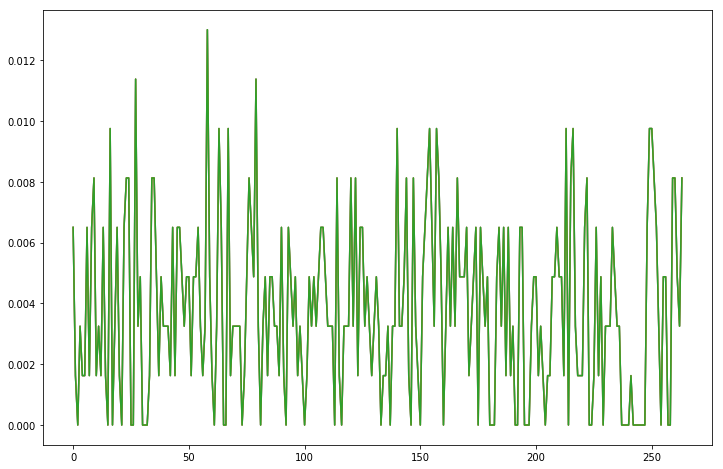

In [169]:
labeled_sample = sample_ic_pd
labeled_sample["label"] = labels
for i in range(len(set(labels))):
    plt.figure(figsize=(12, 8))
    #plt.ylim(0, 1)
    which = labeled_sample.label == i
    labeled_sample[which].sample(n=3, replace=True).count_daily.map(lambda r: pd.Series(r).plot())

In [ ]:
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    return clust_labels

clust_labels = doKmeans(wh1, 5)
kmeans = pd.DataFrame(clust_labels)